In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

from sqlalchemy import and_ ,or_
from pprint import pprint
import pandas as pd
from datetime import timedelta,date
import datetime
import dateutil
import dateutil.parser as parser

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
from Routerstest import session,Measurement,Station,func,minyear,minmon,minday,datemon,dateyear


# Exploratory Climate Analysis

([], <a list of 0 Text xticklabel objects>)

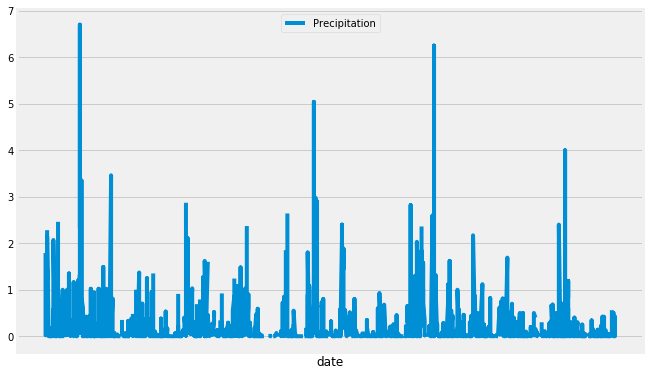

In [3]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date,Measurement.prcp).filter(func.extract("year",Measurement.date)>=minyear).\
filter(or_(and_(func.extract("month",Measurement.date)==minmon,func.extract("year",Measurement.date)==minyear,func.extract("day",Measurement.date)>=minday),
and_(func.extract("month",Measurement.date)>minmon,func.extract("year",Measurement.date)==minyear),and_(func.extract("month",Measurement.date)<=datemon,func.extract("year",Measurement.date)==dateyear))).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpdf=pd.read_sql_query(results,session.bind)

prcpdf['date'] = pd.to_datetime(prcpdf['date'])
prcpdf.set_index('date', inplace=True)
# Sort the dataframe by date
prcpdf.sort_index(ascending=True,inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
prcpdf.plot(figsize=(10,7),ax=ax)
ax.legend(["Precipitation"],loc="upper center")
plt.xticks([])


![precipitation](Images/precipitation.png)

In [4]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdf.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [5]:
# Design a query to show how many stations are available in this dataset?
stationcount=session.query(func.count(Station.station))
results=[cou for cou in stationcount]
pprint(results)

[(9,)]


In [6]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


stationcount1=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
results1=[cou for cou in stationcount1]
pprint(results1)


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [7]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
topstation=results1[0][0]
temprecords=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==topstation)

temprec=[ res for res  in temprecords]
print(temprec)


[(54.0, 85.0, 71.66378066378067)]


USC00519281


Text(0, 0.5, 'Frequency')

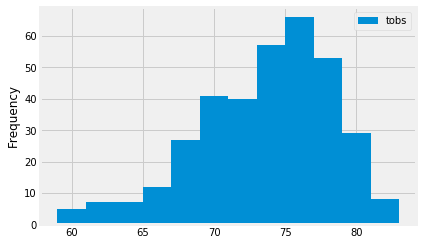

In [8]:
# Choose the station with the highest number of temperature observations.
print(results1[0][0])

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temptopobse=session.query(Measurement.tobs).filter(Measurement.station==results1[0][0]).filter(func.extract("year",Measurement.date)>=minyear).\
filter(or_(and_(func.extract("month",Measurement.date)==minmon,func.extract("year",Measurement.date)==minyear,func.extract("day",Measurement.date)>=minday),
and_(func.extract("month",Measurement.date)>minmon,func.extract("year",Measurement.date)==minyear),and_(func.extract("month",Measurement.date)<=datemon,func.extract("year",Measurement.date)==dateyear))).statement




temptopobsedf=pd.read_sql_query(temptopobse,session.bind)
temptopobsedf.hist(column="tobs",bins=12)
plt.legend(["tobs"],loc="upper right")
plt.title("")
plt.ylabel("Frequency")

![precipitation](Images/station-histogram.png)

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


[(59.0, 74.30789245446661, 84.0)]
74.30789245446661


([], <a list of 0 Text xticklabel objects>)

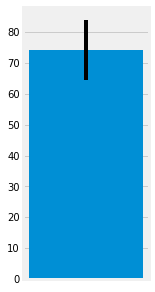

In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

enddate = '2017-03-31'


datee = datetime.datetime.strptime(enddate, "%Y-%m-%d")
stardate=(datetime.datetime(datee.year,datee.month,datee.day)-timedelta(days=365)).strftime("%Y-%m-%d")
calctemp=calc_temps(stardate,enddate)
error=calctemp[0][2]-calctemp[0][1]
print(calctemp)
print(calctemp[0][1])
plt.figure(figsize=(2,5))
plt.bar(0,calctemp[0][1],yerr=error)
plt.xticks([])

In [14]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall=session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).filter(Station.station==Measurement.station).\
 filter(Measurement.date >= stardate).filter(Measurement.date <= enddate).group_by(Station.name).all()
print(rainfall)


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 59.37000000000004), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 30.76), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 173.16999999999993), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 6.2299999999999995), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 88.79000000000009), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 21.619999999999997), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 39.16)]


## Optional Challenge Assignment

In [61]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [162]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
stardate="2017-01-01"
eddate="2017-01-15"
strmon=parser.parse(stardate).month
edmon=parser.parse(eddate).month
strday=parser.parse(stardate).day
edday=parser.parse(eddate).day
stryear=parser.parse(stardate).year
edyear=parser.parse(eddate).year

# Set the start and end date of the trip

d1=date(stryear,strmon,strday)
d2=date(edyear,edmon,edday)


# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


# this will give you a list containing all of the dates
dd = [d1 + timedelta(days=x) for x in range((d2-d1).days + 1)]

#for da in dd:
 #   print(da)
#print(dd)
dnor=[]
dates1=[]
for da in dd:
    #print(da.strftime('%m'))
    daterange='{:02d}-{:02d}-{:02d}'.format(da.year,da.month,da.day)
    dates1.append(daterange)
    
    drange='{:02d}-{:02d}'.format(da.month,da.day)
    dnormals=daily_normals(drange)
    #print(dnormals)
    dnor.append(dnormals)
#print(dnor)
#convert list of tuples to list to created dataframe
dnorlist=[]
for li in dnor:
    for x,y,z in li:
        dnorlist.append([x,y,z])
print(dnorlist)
    




[[62.0, 69.15384615384616, 77.0], [60.0, 69.39622641509433, 77.0], [62.0, 68.9090909090909, 77.0], [58.0, 70.0, 76.0], [56.0, 67.96428571428571, 76.0], [61.0, 68.96491228070175, 76.0], [57.0, 68.54385964912281, 76.0], [57.0, 67.16071428571429, 75.0], [58.0, 67.9298245614035, 78.0], [62.0, 69.74137931034483, 77.0], [57.0, 67.3103448275862, 78.0], [57.0, 67.4074074074074, 81.0], [57.0, 67.25454545454545, 77.0], [58.0, 69.52631578947368, 77.0], [56.0, 69.31372549019608, 78.0]]


In [193]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tempdf=pd.DataFrame(dnorlist,columns=["tmin","tavg","tmax"])

datesdf=pd.DataFrame(dates1,columns=["date"])

tempdf["date"]=datesdf["date"]

tempdf.set_index("date",inplace=True)

tempdf.head(100)


,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


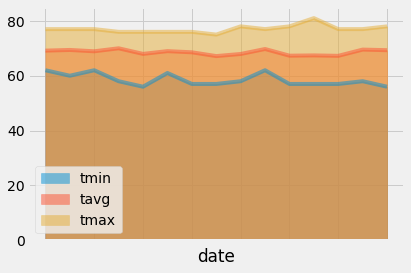

In [192]:
# Plot the daily normals as an area plot with `stacked=False`

tempdf.plot(kind="area",stacked=False)
